# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
import ilqr
from ilqr import iLQR
from ilqr.cost import QRCost, AutoDiffCost
from ilqr.dynamics import constrain
from ilqr.examples.cartpole import CartpoleDynamics

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
dt = 0.05
pole_length = 1.0
dynamics = CartpoleDynamics(dt, l=pole_length)

In [7]:
##QR COST
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(np.array([0.0, 0.0, 0.0, 0.0]))

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
Q[0, 0] = 1.0
Q[1, 1] = Q[4, 4] = 0.0
Q[0, 2] = Q[2, 0] = pole_length
Q[2, 2] = Q[3, 3] = pole_length**2
R = 0.1 * np.eye(dynamics.action_size)

# Terminal state cost.
Q_terminal = 100 * np.eye(dynamics.state_size)

# Instantaneous control cost.
R = np.array([[0.1]])

cost1 = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
## AUTODIFF COST
def l(x, u, i):
    xdiff = x - torch.tensor([0.0, 0.0, 0.0, 1.0, 0.0])
    cost = xdiff.matmul(torch.from_numpy(Q).matmul(xdiff)) + u.matmul(torch.from_numpy(R).matmul(u))
    return cost.reshape(())
def l_terminal(x, i):
    xdiff = x - torch.tensor([0.0, 0.0, 0.0, 1.0, 0.0])
    return xdiff.matmul(torch.from_numpy(Q_terminal).matmul(xdiff)).reshape(())
cost2 = AutoDiffCost(l, l_terminal, 5, 1)

In [9]:
N = 100
x0 = dynamics.augment_state(np.array([0.0, 0.0, np.pi, 0.0]))
#us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
us_init = np.array([[-0.20312974],
 [ 0.75445299],
 [-0.67065794],
 [-0.58457506],
 [ 0.31504851],
 [ 0.69403469],
 [-0.87441201],
 [ 0.09315873],
 [ 0.24865322],
 [ 0.34555092],
 [-0.09809041],
 [ 0.48355731],
 [-0.31129992],
 [ 0.94005631],
 [ 0.52565236],
 [ 0.41329001],
 [ 0.62331586],
 [-0.09652187],
 [ 0.54741909],
 [ 0.17574657],
 [ 0.17317149],
 [-0.49311185],
 [-0.10886177],
 [ 0.40807003],
 [-0.74029825],
 [ 0.2476096 ],
 [-0.94886739],
 [ 0.35000852],
 [ 0.65510562],
 [-0.49662689],
 [-0.78686753],
 [ 0.59761675],
 [ 0.67757525],
 [-0.46285517],
 [-0.45004623],
 [ 0.68267916],
 [-0.61418143],
 [-0.5490947 ],
 [ 0.41327057],
 [ 0.7948301 ],
 [ 0.91957312],
 [-0.97686571],
 [-0.78100975],
 [ 0.52570008],
 [ 0.6913516 ],
 [-0.46137193],
 [ 0.5606604 ],
 [ 0.51350001],
 [ 0.42138328],
 [-0.41926509],
 [ 0.29153209],
 [ 0.38379786],
 [ 0.54619079],
 [ 0.78204759],
 [-0.75674655],
 [-0.99996561],
 [-0.72890028],
 [ 0.01315268],
 [-0.05574027],
 [ 0.65747783],
 [ 0.23044766],
 [ 0.67031861],
 [ 0.85770381],
 [ 0.99664322],
 [-0.13876243],
 [-0.8361856 ],
 [ 0.32481904],
 [ 0.5307379 ],
 [ 0.11915853],
 [ 0.81105147],
 [-0.59875068],
 [ 0.11691902],
 [ 0.4004359 ],
 [ 0.19920961],
 [-0.16914772],
 [-0.97782986],
 [-0.9980017 ],
 [-0.90512067],
 [ 0.8935914 ],
 [-0.71955471],
 [-0.66054544],
 [ 0.21264998],
 [ 0.25569152],
 [-0.18701777],
 [-0.85078087],
 [ 0.46587956],
 [ 0.51375131],
 [-0.47081751],
 [-0.65503213],
 [ 0.46136958],
 [-0.99498939],
 [ 0.27097897],
 [ 0.08812141],
 [-0.65330045],
 [ 0.0075444 ],
 [-0.42236383],
 [-0.53711472],
 [ 0.89327746],
 [-0.63266679],
 [-0.14337624]])

In [12]:
ilqr = iLQR(dynamics, cost1, N)

In [13]:
J_hist = []
t0 = time.time()
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)
print("time", time.time() - t0)

iteration 0 accepted 797.1359213486603 [ 7.83434790e-03 -2.63712646e-03  2.97741479e+00  7.00962347e-03]
iteration 1 accepted 788.8117186438883 [-8.50085025e-03 -1.15473189e-03  2.82473510e+00 -3.01960533e-03]
iteration 2 accepted 760.2312497491708 [-0.02816355  0.01079168  2.53159699 -0.0446952 ]
iteration 3 accepted 754.5845267153177 [-0.03514915 -0.07958686  2.06984548 -0.58296175]
iteration 4 accepted 752.2278752575439 [ 0.12531461 -0.03900019  2.1023558  -0.46217587]
iteration 5 accepted 749.4777000301734 [ 0.07383722  0.04664538  2.04537944 -0.48581777]
iteration 6 accepted 719.183586654621 [ 3.98475449e-02  9.06990626e-04  1.99219576e+00 -3.66917601e-01]
iteration 7 accepted 711.3310913013935 [ 0.01355479 -0.04164494  2.03798941 -0.24855383]
iteration 8 accepted 695.3839594980342 [ 0.00771283 -0.04476746  1.97398185 -0.23001368]
iteration 9 accepted 688.3152318852217 [ 0.01017022 -0.06964657  1.98115116 -0.15158993]
iteration 10 accepted 686.6402653509701 [ 0.00944825 -0.0830625

In [12]:
# Reduce the state to something more reasonable.
print(xs.shape)
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

(101, 5)


In [13]:
print(xs.shape)
t = np.arange(N + 1) * dt
x = xs[:, 0]
x_dot = xs[:, 1]
theta = np.unwrap(xs[:, 2])  # Makes for smoother plots.
theta_dot = xs[:, 3]

(101, 4)


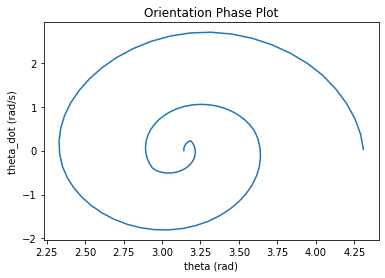

In [14]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

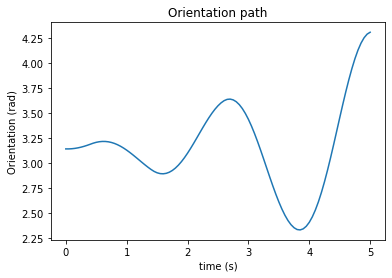

In [15]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

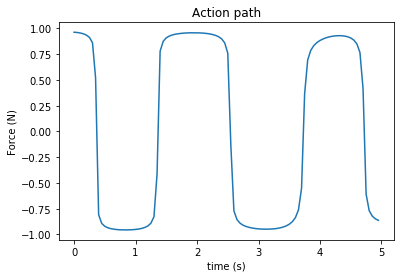

In [16]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

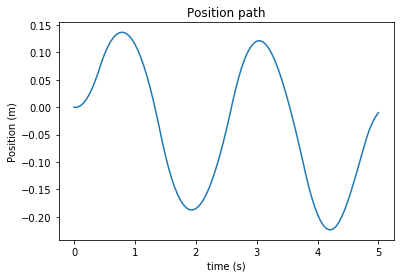

In [17]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

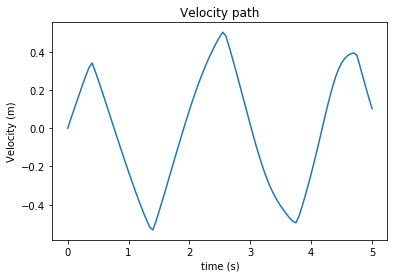

In [18]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

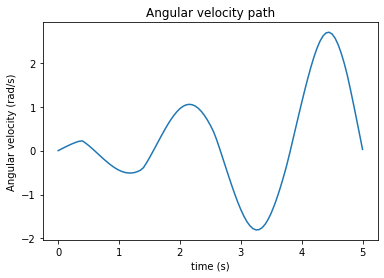

In [19]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

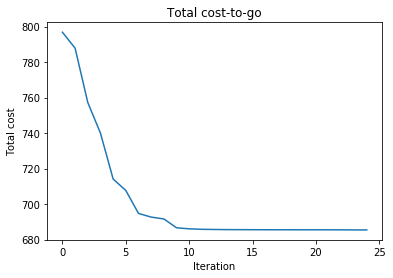

In [20]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")